## Final Project Submission

Please fill out:
* Student name: Brian Tracy
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

raw_data = pd.read_csv('data\kc_house_data.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [2]:
raw_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We need to deal with NaN values.

- For 'yr_renovated', we assume that the house has never been renovated and set the value to 0.0 like other homes not renovated.

- For 'view', we assume that no value means there is no view. There are many 'NONE' values in this column, so we set the nulls to 'NONE'.

- For 'waterfront', we also assume that no value means no waterfront view, and set the value to 'NO'.

In [3]:
df = raw_data.copy()
df['yr_renovated'].fillna(0.0, inplace=True)
df['view'].fillna('NONE', inplace=True)
df['waterfront'].fillna('NO', inplace=True)

# dropping columns we will not need: id, lat, long, sqft_living15, sqft_lot15
# date, and zipcode
# we also will drop the sqft_above (just use sqft_living)
# later decided to drop yr_renovated, will engineer new column for renovation
df.drop(['id', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'zipcode',
         'date', 'sqft_above', 'yr_renovated'], axis=1, inplace=True)


## Baseline model

In [4]:
numerical_data = df.select_dtypes(include='number').copy()

In [5]:
numerical_data.corr()['price'].map(abs).sort_values(ascending=False)

price          1.000000
sqft_living    0.701917
bathrooms      0.525906
bedrooms       0.308787
floors         0.256804
sqft_lot       0.089876
yr_built       0.053953
Name: price, dtype: float64

Here decided to drop sqft_lot and yr_built for baseline model as well.

In [6]:
X = numerical_data.drop(['price', 'sqft_lot', 'yr_built'], axis=1)
y = numerical_data['price']

In [7]:
baseline_model = LinearRegression().fit(X,y).score(X,y)
baseline_model

0.5069513036458111

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

In [9]:
model_v1 = LinearRegression().fit(X_train, y_train)

In [10]:
model_v1.score(X_test,y_test)

0.4852484156831536

In [12]:
model_v1.coef_

array([-57779.07216263,   5073.97505272,    316.02754652,  -2060.11712557])

In [13]:
model_v1.intercept_

70620.48702331533

In [11]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=model_v1,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:", baseline_scores["train_score"].mean())
print("Test score:", baseline_scores["test_score"].mean())

Train score: 0.5141531604386964
Test score: 0.49984402999190375


Looks like a baseline model scores about 50, which we hope to improve by converting and adding back in categorical data first

## Convert categorical data

In [15]:
categorical_data = df.select_dtypes(exclude='number').copy()
categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   waterfront     21597 non-null  object
 1   view           21597 non-null  object
 2   condition      21597 non-null  object
 3   grade          21597 non-null  object
 4   sqft_basement  21597 non-null  object
dtypes: object(5)
memory usage: 843.8+ KB


We have 6 categorical features to evaluate:
(technically 2 are numerical we are adapting)
- 'waterfront': engineer new boolean 'is_waterfront'
- 'grade': change to numeric
- 'sqft_basement': engineer new boolean 'has_basement'
- 'yr_renovated': engineer new boolean 'been_renovated'
    *note this uses the raw_data from original import

In [16]:
# set up new dataframe to concat later with numerical dataframe
converted_features = pd.DataFrame([])

# new 'is_waterfront' feature (boolean)
converted_features['is_waterfront'] = categorical_data.waterfront\
                                                     .map({'NO': 0, 'YES': 1})

# updated 'grade' feature
converted_features['grade'] = categorical_data.grade\
                                                  .map(lambda x: x.split()[0])

# 'sqft_basement' has some values of '?', before engineering new feature these
# must be converted to 0.0
categorical_data.sqft_basement.replace(to_replace='?', value=0.0, 
                                       inplace=True)
# then convert the whole column to float
categorical_data['sqft_basement'] = categorical_data.sqft_basement\
                                                    .astype('float')
# new 'has_basement' feature (boolean)
converted_features['has_basement'] = categorical_data.sqft_basement\
                                           .apply(lambda x: 1 if x > 1 else 0)

# new 'been_renovated' feature (boolean)
converted_features['been_renovated'] = raw_data.yr_renovated\
                                           .apply(lambda x: 1 if x > 0 else 0)

In [23]:
converted_features

,is_waterfront,grade,has_basement,been_renovated
0,0,7,0,0
1,0,7,1,1
2,0,6,0,0
3,0,7,1,0
4,0,8,0,0
...,...,...,...,...
21592,0,8,0,0
21593,0,8,0,0
21594,0,7,0,0
21595,0,8,0,0


- 'view': onehotencode (NONE, AVERAGE, GOOD, FAIR, EXCELLENT)
- 'condition': onehotencode (Average, Good, Very Good, Fair, Poor)

In [20]:
from sklearn.preprocessing import OneHotEncoder

categories = ['view', 'condition']
temp_df = categorical_data[categories].copy()

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(temp_df)

column_names = ohe.get_feature_names()

ohe_encoded = ohe.transform(temp_df)

temp_df_encoded = pd.DataFrame(ohe_encoded, columns=column_names)

In [21]:
temp_df_encoded

,x0_EXCELLENT,x0_FAIR,x0_GOOD,x0_NONE,x1_Fair,x1_Good,x1_Poor,x1_Very Good
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
21592,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
merged_df = pd.concat([numerical_data, converted_features, temp_df_encoded],
                     axis=1)

In [27]:
merged_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,is_waterfront,grade,has_basement,been_renovated,x0_EXCELLENT,x0_FAIR,x0_GOOD,x0_NONE,x1_Fair,x1_Good,x1_Poor,x1_Very Good
0,221900.0,3,1.00,1180,5650,1.0,1955,0,7,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,538000.0,3,2.25,2570,7242,2.0,1951,0,7,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,180000.0,2,1.00,770,10000,1.0,1933,0,6,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,604000.0,4,3.00,1960,5000,1.0,1965,0,7,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,510000.0,3,2.00,1680,8080,1.0,1987,0,8,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,2009,0,8,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21593,400000.0,4,2.50,2310,5813,2.0,2014,0,8,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21594,402101.0,2,0.75,1020,1350,2.0,2009,0,7,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21595,400000.0,3,2.50,1600,2388,2.0,2004,0,8,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Model Version 2

Model version 2 (bringing in converted categoricals)

In [28]:
X = merged_df.drop('price', axis=1)
y = merged_df['price']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

In [33]:
model_v2 = LinearRegression().fit(X_train,y_train)

In [36]:
model_v2.score(X_test,y_test)

0.6590650658767253

Looks like we are up to a score of 65 from 50

In [40]:
merged_df.corr()['price'].abs().sort_values(ascending=False)

price             1.000000
sqft_living       0.701917
bathrooms         0.525906
x0_NONE           0.356243
bedrooms          0.308787
x0_EXCELLENT      0.303059
is_waterfront     0.264306
floors            0.256804
x0_GOOD           0.182932
has_basement      0.178264
been_renovated    0.117543
x0_FAIR           0.092597
sqft_lot          0.089876
x1_Very Good      0.057531
yr_built          0.053953
x1_Fair           0.051432
x1_Good           0.030759
x1_Poor           0.019886
Name: price, dtype: float64

In [44]:
merged_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,is_waterfront,has_basement,been_renovated,x0_EXCELLENT,x0_FAIR,x0_GOOD,x0_NONE,x1_Fair,x1_Good,x1_Poor,x1_Very Good
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.00000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1970.999676,0.006760,0.38510,0.034449,0.014678,0.015280,0.023522,0.902209,0.007871,0.262861,0.001343,0.078761
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,29.375234,0.081944,0.48663,0.182384,0.120263,0.122667,0.151557,0.297039,0.088373,0.440198,0.036620,0.269372
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1951.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1975.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,1997.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,2015.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Features in depth

### sqft_living

<AxesSubplot:>

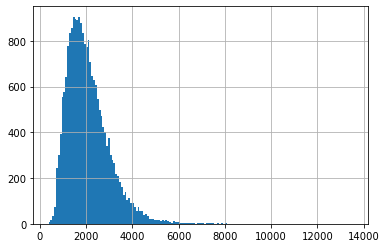

In [43]:
merged_df.sqft_living.hist(bins='auto')